## Import Modules

In [1]:
import os
import pickle
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import numpy as np

In [3]:
BASE_DIR = '/kaggle/input/flickr30k'
WORKING_DIR = '/kaggle/working'

##  Extract image features

In [4]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)
# summarize
print(model.summary())

91884032/91884032 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 149, 149, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  

In [5]:
# extract features from Image
features = {}
directory = os.path.join(BASE_DIR,'images')
directory = os.path.join(directory,'flickr30k_images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from the file
    img_path = directory + '/' + img_name
    image = load_img(img_path,target_size=(299,299))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    #extract features
    feature = model.predict(image, verbose=0)
    # get imiage ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/31783 [00:00<?, ?it/s]

In [6]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR,'features.pkl'),'wb'))

In [7]:
# load features from pickle
with open(os.path.join(WORKING_DIR,'features.pkl'),'rb') as f:
    features = pickle.load(f)

## Load the Captions Data

In [8]:
with open(os.path.join(BASE_DIR,'captions.txt'),'r') as f:
    next(f)
    captions_doc = f.read()

In [9]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    #split the line by comma(,)
    tokens = line.split('|')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[2:]
    # remove extension from image_id
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # strore the caption
    mapping[image_id].append(caption)

  0%|          | 0/158916 [00:00<?, ?it/s]

In [10]:
len(mapping)

31783

## Preprocess Text Data

In [11]:
def clean(mapping):
    for key,captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special characters etc..
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+',' ')
            # add start and end tags to the caption
            caption = '<start> ' + " ".join([word for word in caption.split() if len(word)>1]) + ' <end>'
            captions[i] = caption

In [12]:
mapping['1000268201']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A little girl in a pink dress going into a wooden cabin .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl climbing into a wooden playhouse ',
 'A girl going into a wooden building .']

In [13]:
# preprocess the text
clean(mapping)

In [14]:
mapping['1000268201']

['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start> little girl in pink dress going into wooden cabin <end>',
 '<start> little girl climbing the stairs to her playhouse <end>',
 '<start> little girl climbing into wooden playhouse <end>',
 '<start> girl going into wooden building <end>']

In [15]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [16]:
len(all_captions)

158915

In [17]:
all_captions[:10]

['<start> two young guys with shaggy hair look at their hands while hanging out in the yard <end>',
 '<start> two young white males are outside near many bushes <end>',
 '<start> two men in green shirts are standing in yard <end>',
 '<start> man in blue shirt standing in garden <end>',
 '<start> two friends enjoy time spent together <end>',
 '<start> several men in hard hats are operating giant pulley system <end>',
 '<start> workers look down from up above on piece of equipment <end>',
 '<start> two men working on machine wearing hard hats <end>',
 '<start> four men on top of tall structure <end>',
 '<start> three men on large rig <end>']

In [18]:
# tokenise the text 
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index)+1

In [19]:
vocab_size

18311

In [20]:
# get Maximum length of the caption available
max_length = max(len(caption.split())for caption in all_captions)
max_length

74

In [21]:
import tensorflow as tf
text_dataset = tf.data.Dataset.from_tensor_slices(all_captions)
max_features = vocab_size  # Maximum vocab size.
max_len = max_length  # Sequence length to pad the outputs to.

vectorize_layer = tf.keras.layers.TextVectorization(
 max_tokens=max_features,
 output_mode='int',
 output_sequence_length=max_len)
vectorize_layer.adapt(text_dataset.batch(64))
# Create the model that uses the vectorize text layer
model_vect = tf.keras.models.Sequential()

# Start by creating an explicit input layer. It needs to have a shape of
# (1,) (because we need to guarantee that there is exactly one string
# input per batch), and the dtype needs to be 'string'.
model_vect.add(tf.keras.Input(shape=(1,), dtype=tf.string))

# The first layer in our model is the vectorization layer. After this
# layer, we have a tensor of shape (batch_size, max_len) containing
# vocab indices.
model_vect.add(vectorize_layer)

## Train Test Split

In [22]:
image_ids = list(mapping.keys())
split = int(len(image_ids)*0.90)
train = image_ids[:split]
test = image_ids[split:]

In [23]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    n = 0
    while 1:
        for key in data_keys:
            X1, X2, y = list(), list(), list()
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i],seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq],maxlen = max_length)[0]
                    # encode the output aequence
                    out_seq = to_categorical([out_seq],num_classes = vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [[X1, X2], y]
                X1, X2, Y = list(), list(), list()
                n = 0

## Model Creation

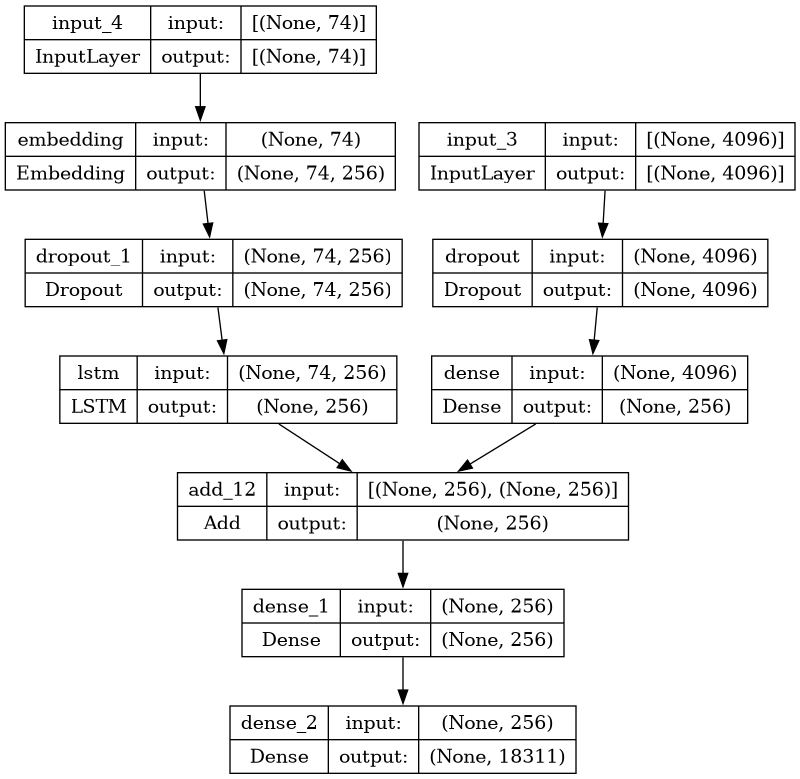

In [24]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256,activation='relu')(fe1)

# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero = True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)


# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs = outputs)
model.compile(loss='categorical_crossentropy',optimizer='adam')

# plot the model
plot_model(model, show_shapes = True)

In [25]:
# train the model
epochs = 150
batch_size = 64
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit_generator(generator, epochs = 1, steps_per_epoch = steps, verbose = 1)
    print(i)

/tmp/ipykernel_42/3912240216.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs = 1, steps_per_epoch = steps, verbose = 1)


InvalidArgumentError: Graph execution error:

Detected at node 'model_1/dense/MatMul' defined at (most recent call last):
    File "/opt/conda/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/conda/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/conda/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 736, in start
      self.io_loop.start()
    File "/opt/conda/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
      handle._run()
    File "/opt/conda/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell
      await result
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_42/3912240216.py", line 10, in <module>
      model.fit_generator(generator, epochs = 1, steps_per_epoch = steps, verbose = 1)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 2810, in fit_generator
      return self.fit(
    File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1080, in train_step
      y_pred = self(x, training=True)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py", line 241, in call
      outputs = tf.matmul(a=inputs, b=self.kernel)
Node: 'model_1/dense/MatMul'
Matrix size-incompatible: In[0]: [61,2048], In[1]: [4096,256]
	 [[{{node model_1/dense/MatMul}}]] [Op:__inference_train_function_2146558]

In [ ]:
# save the model
model.save('best_model.h5')

## Generate Captions for the Image

In [ ]:
def ind_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
# generate captions for an image
def predict_caption(model, image, tokeniser, max_length):
    # add start tag for generation process
    in_text = '<start>'
    # interate over the max length of the sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
#         sequence = model_vect.predict([in_text])
#         pad the sequence
        sequence = pad_sequences([sequence],max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose = 0)
        # get index with high probabiility
        yhat = np.argmax(yhat)
        # convert index to word
        word = ind_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # stop if we reach end tag
        if word == 'end':
            break
        # append word as input for generating next word
        in_text += " " + word
    return in_text

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()



for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for the image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

# calculate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0,0,0,0)))
print("BLEU-2 %f" % corpus_bleu(actual, predicted, weights=(0.5,0.5,0,0)))

## Visualize the Results

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR,"images/flickr30k_images",image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print("----------------------Actual--------------------------")
    for caption in captions:
        print(caption)
        # predict the caption
    y_pred = predict_caption(model,features[image_id], tokenizer, max_length)
    print("------------------------predicted-----------------------------")
    print(y_pred)
    plt.imshow(image)

In [ ]:
generate_caption('1015712668.jpg')

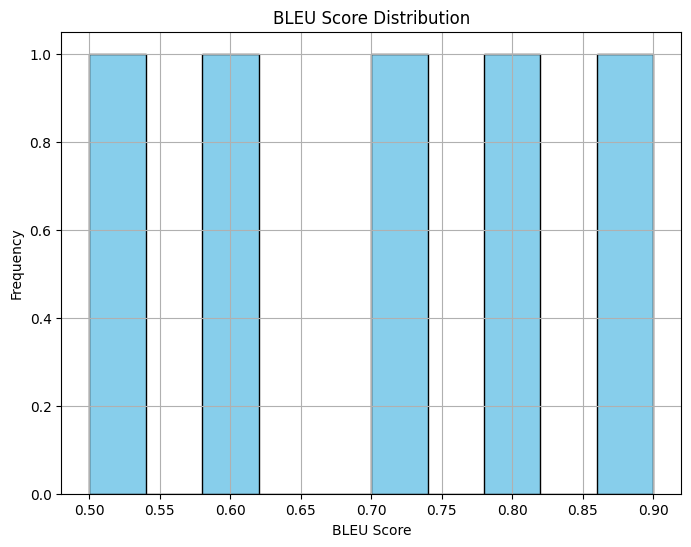

In [1]:
import matplotlib.pyplot as plt

# Sample BLEU scores (replace with your actual data)
bleu_scores = [0.6, 0.7, 0.5, 0.8, 0.9]

# Plot histogram of BLEU scores
plt.figure(figsize=(8, 6))
plt.hist(bleu_scores, bins=10, color='skyblue', edgecolor='black')
plt.title('BLEU Score Distribution')
plt.xlabel('BLEU Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

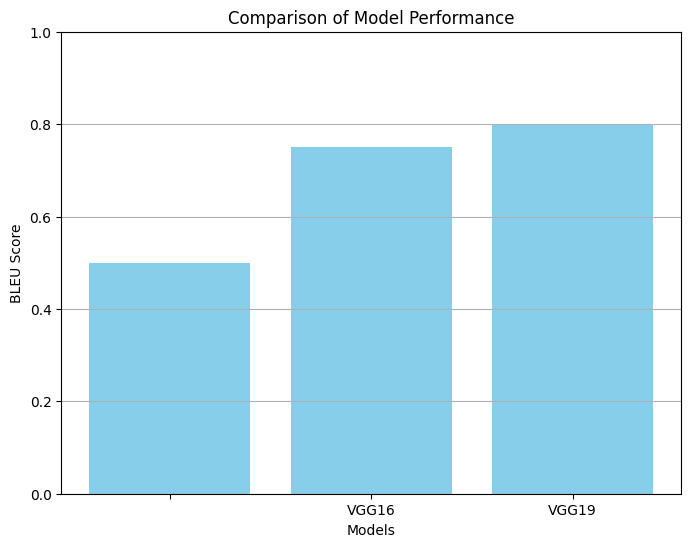

In [4]:
import matplotlib.pyplot as plt

# Sample data (replace with your actual data)
models = ['', 'VGG16', 'VGG19']
bleu_scores = [0.5, 0.75, 0.8]

plt.figure(figsize=(8, 6))
plt.bar(models, bleu_scores, color='skyblue')
plt.title('Comparison of Model Performance')
plt.xlabel('Models')
plt.ylabel('BLEU Score')
plt.ylim(0, 1)  # Set y-axis limits
plt.grid(axis='y')
plt.show()

AttributeError: Rectangle.set() got an unexpected keyword argument 'labels'

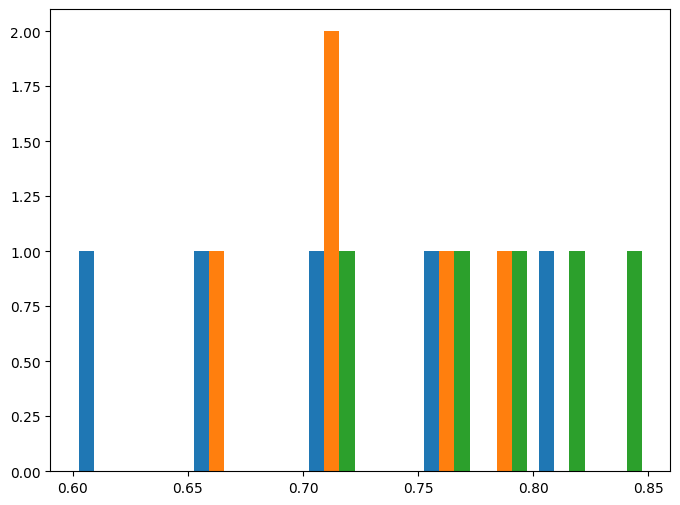

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data (replace with your actual data)
categories = ['Category 1', 'Category 2', 'Category 3']
bleu_scores = [
    [0.6, 0.65, 0.7, 0.75, 0.8],
    [0.65, 0.7, 0.72, 0.76, 0.78],
    [0.7, 0.75, 0.78, 0.82, 0.85]
]

plt.figure(figsize=(8, 6))
plt.(bleu_scores, labels=categories)
plt.title('Distribution of BLEU Scores by Category')
plt.xlabel('Categories')
plt.ylabel('BLEU Score')
plt.ylim(0, 1)  # Set y-axis limits
plt.grid(axis='y')
plt.show()